# Phase 3: ML Model Development for Commodity Price Prediction
This notebook develops and compares multiple machine learning models using engineered features from Phase 2.

**Models Covered:** Linear Regression, Random Forest, XGBoost, Neural Network (Deep Learning)
**Workflow:** Data loading, train-test split, model training, evaluation, hyperparameter tuning, feature importance, final model selection and saving.

## 1. Import Libraries & Load Engineered Features
Import necessary libraries and load the engineered dataset and scaler from Phase 2.

In [2]:
!pip freeze > requirements.txt

In [1]:
# Import libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
# TensorFlow can sometimes cause deep recursion during import in some environments.
# Increase recursion limit and reduce TF logging before importing.
sys.setrecursionlimit(10000)
os.environ.setdefault('TF_CPP_MIN_LOG_LEVEL', '2')
import tensorflow as tf
# prefer using tf.keras to avoid conflicts with standalone keras package
# from tensorflow import keras  <-- removed to prevent potential import conflicts
import pickle
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load engineered features and scaler
features_file = r"D:\CUDA_Experiments\Git_HUB\AgriCast360\Script\Processed_Data\Features_Engineered.csv"
scaler_file = r"D:\CUDA_Experiments\Git_HUB\AgriCast360\Script\scaler.pkl"

df = pd.read_csv(features_file)

# Try joblib first (common for sklearn scalers), fallback to pickle
scaler = None
try:
    scaler = joblib.load(scaler_file)
    print("✅ Scaler loaded with joblib.")
except Exception as e_joblib:
    try:
        with open(scaler_file, 'rb') as f:
            scaler = pickle.load(f)
        print("✅ Scaler loaded with pickle.")
    except Exception as e_pickle:
        raise RuntimeError(f"Failed to load scaler file. joblib error: {e_joblib}; pickle error: {e_pickle}")

print(f"✅ Data and scaler loaded. Shape: {df.shape}")


✅ Scaler loaded with joblib.
✅ Data and scaler loaded. Shape: (14905, 112)
✅ Scaler loaded with joblib.
✅ Data and scaler loaded. Shape: (14905, 112)


## 2. Train-Test Split & Data Preparation
Split the data into training and testing sets using a time-based split. Display statistics and class distribution.

In [2]:
# Prepare features and target
drop_cols = ['Commodity', 'Market', 'Variety', 'Arrival_Date', 'date', 'Commodity_Market', 'Min_Price', 'Max_Price', 'Arrival']
feature_cols = [col for col in df.columns if col not in drop_cols + ['Modal_Price']]
X = df[feature_cols].copy()
y = df['Modal_Price'].copy()

# Time-based split (assume sorted by Arrival_Date)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Target mean (train): {y_train.mean():.2f}, (test): {y_test.mean():.2f}")

Train shape: (11924, 108), Test shape: (2981, 108)
Target mean (train): 4281.27, (test): 5367.63


## 3. Baseline Model (Linear Regression)
Train a linear regression model as baseline. Evaluate using MAE, RMSE, R² score and visualize predictions vs actual values.

Linear Regression MAE: 289.10
Linear Regression RMSE: 569.49
Linear Regression R²: 0.981


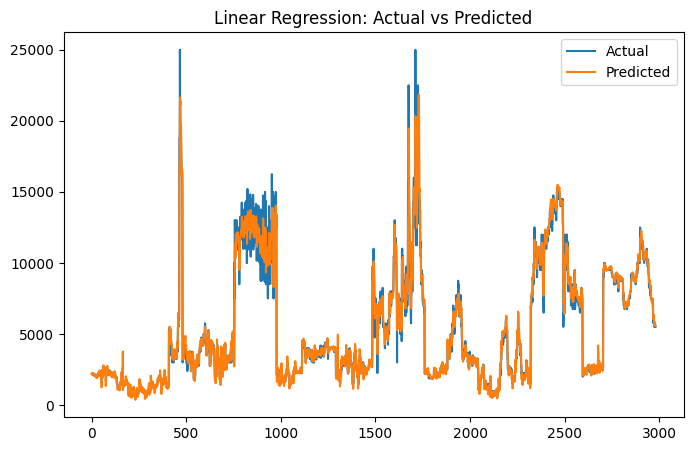

In [7]:
# Encode categorical features and ensure train/test have same columns
X_combined = pd.concat([X_train, X_test], axis=0)
X_combined_enc = pd.get_dummies(X_combined, drop_first=True)

# Split back to train/test
X_train_enc = X_combined_enc.iloc[:len(X_train)].copy()
X_test_enc = X_combined_enc.iloc[len(X_train):].copy()

# Train baseline linear regression model
lr = LinearRegression()
lr.fit(X_train_enc, y_train)
y_pred_lr = lr.predict(X_test_enc)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression MAE: {mae_lr:.2f}")
print(f"Linear Regression RMSE: {rmse_lr:.2f}")
print(f"Linear Regression R²: {r2_lr:.3f}")

plt.figure(figsize=(8,5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_lr, label='Predicted')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.show()

## 4. Random Forest Regressor
Train Random Forest regressor. Evaluate performance metrics and compare with baseline model.

Random Forest MAE: 159.86
Random Forest RMSE: 437.96
Random Forest R²: 0.989


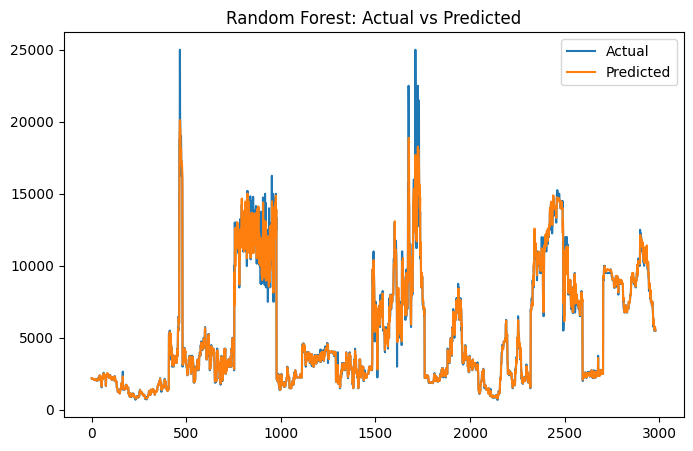

In [9]:
# Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)

# Use the one-hot encoded feature matrices (avoid string columns like 'State'/'District')
rf.fit(X_train_enc, y_train)
y_pred_rf = rf.predict(X_test_enc)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MAE: {mae_rf:.2f}")
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest R²: {r2_rf:.3f}")

plt.figure(figsize=(8,5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_rf, label='Predicted')
plt.title('Random Forest: Actual vs Predicted')
plt.legend()
plt.show()

## 5. Gradient Boosting (XGBoost)
Train XGBoost regressor with optimized parameters. Evaluate performance and compare with previous models. Display feature importance.

XGBoost MAE: 148.60
XGBoost RMSE: 392.51
XGBoost R²: 0.991


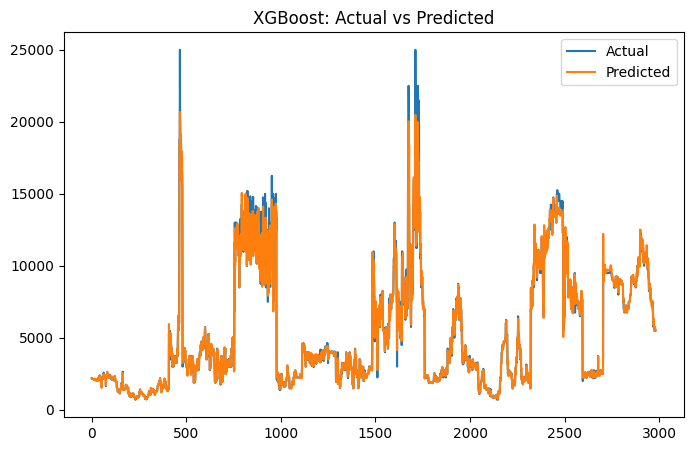

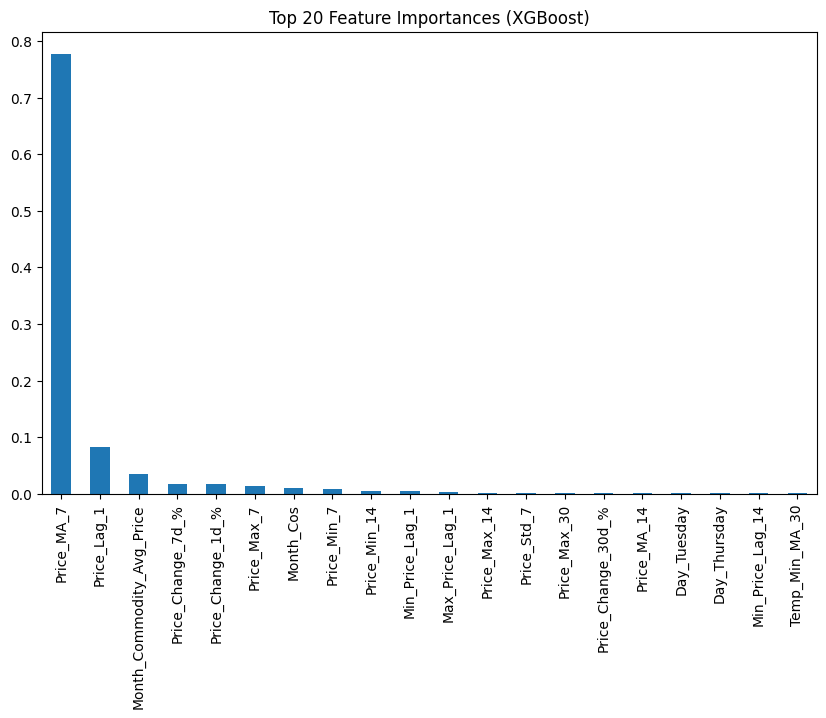

In [11]:
# Train XGBoost Regressor
# Use the one-hot encoded numeric feature matrices created earlier: X_train_enc / X_test_enc
xgb_model = xgb.XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_model.fit(X_train_enc, y_train)
y_pred_xgb = xgb_model.predict(X_test_enc)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MAE: {mae_xgb:.2f}")
print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"XGBoost R²: {r2_xgb:.3f}")

plt.figure(figsize=(8,5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_xgb, label='Predicted')
plt.title('XGBoost: Actual vs Predicted')
plt.legend()
plt.show()

# Feature importance (use the encoded column names)
xgb_importance = pd.Series(xgb_model.feature_importances_, index=X_train_enc.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
xgb_importance.head(20).plot(kind='bar')
plt.title('Top 20 Feature Importances (XGBoost)')
plt.show()

## 6. Neural Network (Deep Learning)
Build and train a neural network using TensorFlow/Keras. Monitor training/validation loss and evaluate on test set.

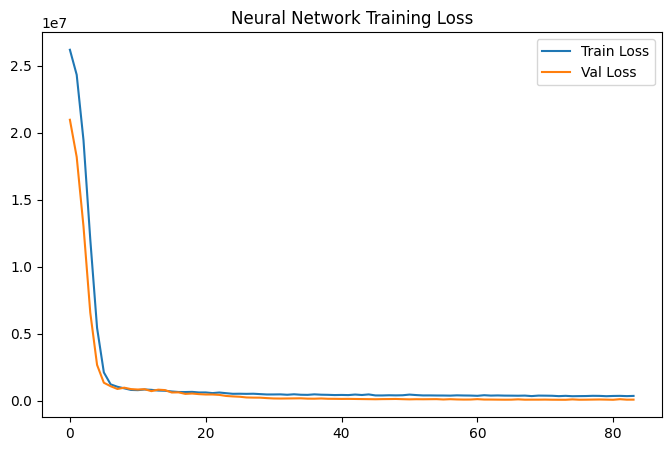

94/94 [==============================] - 1s 4ms/step
Neural Network MAE: 232.13
Neural Network RMSE: 439.56
Neural Network R²: 0.988
Neural Network MAE: 232.13
Neural Network RMSE: 439.56
Neural Network R²: 0.988


In [13]:
# Build and train neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Use the one-hot encoded numeric feature matrices created earlier: X_train_enc / X_test_enc
# Convert to numeric numpy arrays (float32) to avoid dtype/object issues when converting to tensors
X_train_nn = X_train_enc.to_numpy().astype('float32')
X_test_nn = X_test_enc.to_numpy().astype('float32')
y_train_nn = y_train.to_numpy().astype('float32')

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_nn.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_nn, y_train_nn, validation_split=0.2, epochs=100, batch_size=64, callbacks=[early_stop], verbose=0)

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Neural Network Training Loss')
plt.legend()
plt.show()

y_pred_nn = model.predict(X_test_nn).flatten()
mae_nn = mean_absolute_error(y_test, y_pred_nn)
rmse_nn = mean_squared_error(y_test, y_pred_nn, squared=False)
r2_nn = r2_score(y_test, y_pred_nn)

print(f"Neural Network MAE: {mae_nn:.2f}")
print(f"Neural Network RMSE: {rmse_nn:.2f}")
print(f"Neural Network R²: {r2_nn:.3f}")

## 7. Model Evaluation & Comparison
Compare all models using MAE, RMSE, R² and MAPE metrics. Create comparison tables and visualizations. Identify best performing model.

               Model         MAE        RMSE        R2      MAPE
0  Linear Regression  289.104741  569.491525  0.980680  6.078386
1      Random Forest  159.862241  437.964458  0.988574  2.201101
2            XGBoost  148.601198  392.511308  0.990822  2.177293
3     Neural Network  232.127964  439.555072  0.988490  4.923841


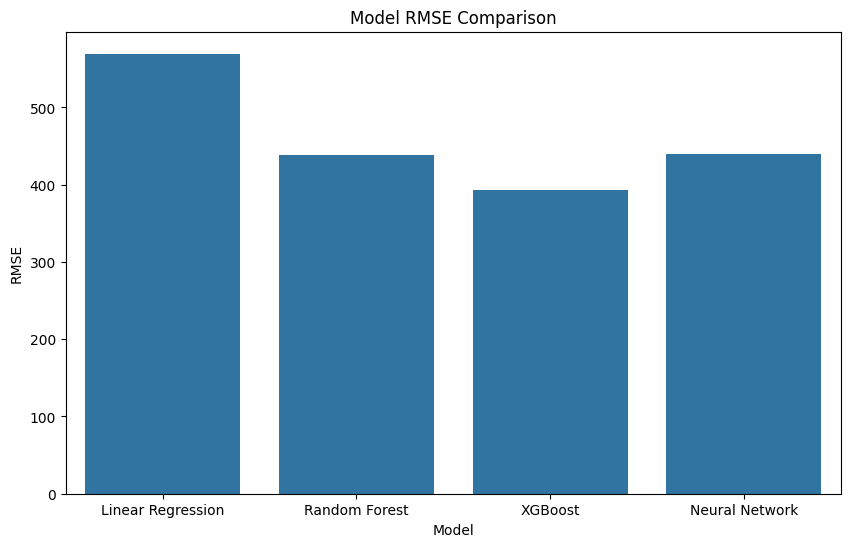

In [14]:
# Compare models
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'Neural Network'],
    'MAE': [mae_lr, mae_rf, mae_xgb, mae_nn],
    'RMSE': [rmse_lr, rmse_rf, rmse_xgb, rmse_nn],
    'R2': [r2_lr, r2_rf, r2_xgb, r2_nn],
    'MAPE': [mape(y_test, y_pred_lr), mape(y_test, y_pred_rf), mape(y_test, y_pred_xgb), mape(y_test, y_pred_nn)]
})
print(results)

plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='RMSE', data=results)
plt.title('Model RMSE Comparison')
plt.show()

## 8. Hyperparameter Tuning
Perform GridSearchCV or RandomizedSearchCV on top 2-3 models to optimize hyperparameters. Document best parameters and performance improvements.

In [16]:
# Example: RandomizedSearchCV for Random Forest
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_dist, n_iter=10, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
rf_search.fit(X_train_enc, y_train)

print(f"Best RF Params: {rf_search.best_params_}")
print(f"Best RF CV Score: {-rf_search.best_score_:.2f}")

# Train final Random Forest with best parameters
rf_tuned = RandomForestRegressor(**rf_search.best_params_, random_state=42, n_jobs=-1)
rf_tuned.fit(X_train_enc, y_train)
y_pred_rf_tuned = rf_tuned.predict(X_test_enc)

mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)
rmse_rf_tuned = mean_squared_error(y_test, y_pred_rf_tuned, squared=False)
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)

print(f"\nTuned Random Forest MAE: {mae_rf_tuned:.2f}")
print(f"Tuned Random Forest RMSE: {rmse_rf_tuned:.2f}")
print(f"Tuned Random Forest R²: {r2_rf_tuned:.3f}")

KeyboardInterrupt: 

## 9. Feature Importance Analysis
Extract and visualize feature importance from tree-based models. Compare with Phase 1 correlation analysis. Identify critical features.

In [ ]:
# Feature importance from Random Forest
rf_importance = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
rf_importance.head(20).plot(kind='bar')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.show()

# Compare with XGBoost importance (already plotted above)

## 10. Final Model Selection & Save
Select best model based on evaluation metrics. Save the final model. Create prediction function for inference. Generate final performance report.

In [ ]:
# Select and save best model (example: XGBoost)
final_model = xgb_model
model_file = r"D:\CUDA_Experiments\Git_HUB\AgriCast360\Script\final_model_xgb.pkl"
with open(model_file, 'wb') as f:
    pickle.dump(final_model, f)
print(f"✅ Final model saved to: {model_file}")

# Prediction function
def predict_price(features, model=final_model, scaler=scaler):
    features_scaled = scaler.transform([features])
    return model.predict(features_scaled)[0]

# Final performance report
print("\nFinal Model Performance:")
print(f"MAE: {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R²: {r2_xgb:.3f}")